In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import obspy
from obspy import Stream
from obspy.clients.fdsn import Client
from pnwstore.mseed import WaveformClient
from obspy import Stream
from datetime import timedelta
from tqdm import tqdm
import csv
import random
from itertools import islice
import time 

In [ ]:
#--------------Initiate clients and constants----------------#
# Define clients
# client_iris = Client("IRIS")
client_ncedc = Client("NCEDC")
client_waveform = WaveformClient()

# Define constants
sampling_rate = 100  # Hz
pre_arrival_time = 50
window_length = 150

# Load the arrival table and define the output file names
assoc_df = pd.read_csv('/home/hbito/cascadia_obs_ensemble_backup/data/datasets_all_regions/arrival_assoc_origin_2010_2015_reloc_cog_ver3.csv', index_col=0)
output_waveform_file = "/home/hbito/cascadia_obs_ensemble_backup/data/datasets_all_regions/waveforms_HH_BH_on_the_fly_bulk_backup2.h5"
output_metadata_file = "/home/hbito/cascadia_obs_ensemble_backup/data/datasets_all_regions/metadata_HH_BH_on_the_fly_bulk_backup2.csv"
error_log_file = "/home/hbito/cascadia_obs_ensemble_backup/data/datasets_all_regions/save_errors_on_the_fly_bulk_backup2.csv"

# Preprocess dataframe
assoc_df[['network', 'station']] = assoc_df['sta'].str.split('.', expand=True)
assoc_df['event_id'] = 'ev' + assoc_df['otime'].astype(str).str.replace('.', '_')


In [3]:
# Define the function to reorder the traces in a stream
def order_traces(stream: Stream, expected_len: int) -> np.ndarray:
    """
    Converts an ObsPy stream into a (3, expected_len) numpy array, 
    consistently ordered as [Z, E, N].

    Parameters:
    - stream: ObsPy Stream containing cleaned traces (padded to expected_len)
    - expected_len: Target length of each waveform trace

    Returns:
    - data_array: np.ndarray of shape (3, expected_len)
    """
    # Fixed component order: Z → 0, E → 1, N → 2
    comp_to_index = {"Z": 0, "E": 1, "N": 2}
    data_list = [np.zeros(expected_len) for _ in range(3)]  # Default to zeros

    for tr in stream:
        chan_suffix = tr.stats.channel[-1]
        if chan_suffix in comp_to_index:
            idx = comp_to_index[chan_suffix]
            data_list[idx] = tr.data  

    return np.vstack(data_list)  # Shape: (3, expected_len)

In [ ]:
# #--------------Gather Station Information----------------#
# # Obtain unique network-station combinations
# unique_ns = assoc_df.sta.unique()

# # Define the start and end times for requesting station information
# starttime_bulk = obspy.UTCDateTime("2010-01-01T00:00:00")
# endtime_bulk = obspy.UTCDateTime("2015-12-31T23:59:59")

# # Make a list of stations for bulk request 
# bulk =[]
# for u_ns in unique_ns:
#     n,s = u_ns.split('.')

#     for bi in ['EH?', 'BH?', 'HH?']:
#         line = (n, s, '*', bi, starttime_bulk, endtime_bulk)
#         bulk.append(line)

# # Make a bulk request 
# inv = client_iris.get_stations_bulk(bulk, level='channel')
# time.sleep(0.2)

In [5]:
#--------------Gather Waveform Information----------------#
# Obtain uniquee otime-network-station combinations
unique_n_s_otime = assoc_df.drop_duplicates(['event_id', 'network', 'station'],keep='first').reset_index(drop=True)
unique_n_s_otime


,sta,pick_time,arid,iphase,prob,orid,phase,timeres,slatitude,slongitude,...,nass,p_picks,s_picks,rms,nsphz,gap,algorithm,network,station,event_id
0,UW.PCMD,1.262305e+09,0,P,0.680,0,P,0.049,46.888962,-122.301483,...,7,2,5,1.081,5.0,235.831208,genie,UW,PCMD,ev1262304917_262282
1,UW.RVW,1.262305e+09,1,P,0.680,0,P,1.264,46.149750,-122.742996,...,7,2,5,1.081,5.0,235.831208,genie,UW,RVW,ev1262304917_262282
2,UW.GNW,1.262305e+09,3,S,0.680,0,S,2.402,47.564130,-122.824980,...,7,2,5,1.081,5.0,235.831208,genie,UW,GNW,ev1262304917_262282
3,PB.B013,1.262305e+09,4,S,0.680,0,S,-0.651,47.813000,-122.910797,...,7,2,5,1.081,5.0,235.831208,genie,PB,B013,ev1262304917_262282
4,PB.B943,1.262305e+09,5,S,0.680,0,S,-0.511,47.813202,-122.911301,...,7,2,5,1.081,5.0,235.831208,genie,PB,B943,ev1262304917_262282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690483,7D.J11D,1.435102e+09,1004326,P,0.694,63886,P,-0.336,43.541599,-126.368599,...,9,4,5,0.447,5.0,247.683119,genie,7D,J11D,ev1435101498_841147
690484,7D.J19D,1.435102e+09,1004327,P,0.694,63886,P,-0.419,44.179001,-126.271202,...,9,4,5,0.447,5.0,247.683119,genie,7D,J19D,ev1435101498_841147
690485,7D.J10D,1.435102e+09,1004328,P,0.694,63886,P,-0.505,43.348499,-125.545097,...,9,4,5,0.447,5.0,247.683119,genie,7D,J10D,ev1435101498_841147
690486,7D.J27D,1.435102e+09,1004329,P,0.694,63886,P,0.915,44.848900,-126.308296,...,9,4,5,0.447,5.0,247.683119,genie,7D,J27D,ev1435101498_841147


In [6]:
# Define functions to append entries for the bulk request
def append_bulk_lists_chunks(bulk_waveforms, n, s, bi, trace_start, trace_end, day_end, next_day_start):
    """
    Append waveform requests to the bulk list based on the availability of HH? and BH? channels. If the stream runs over the midnight, split the request into two.
    """
    if day_end > trace_end:
        # If the trace end is within the same day, we can use HH?
        bulk_waveforms.append((n, s, '*', bi, trace_start, trace_end))
    else:
        # If the trace end goes beyond the day, we need to adjust
        bulk_waveforms.append((n, s, '*', bi, trace_start, day_end))
        bulk_waveforms.append((n, s, '*', bi, next_day_start, trace_end))
    return bulk_waveforms

In [7]:
def append_bulk_lists(bulk_waveforms, n, s, bi, trace_start, trace_end):
    """
    Append waveform requests to the bulk list based on the availability of HH? and BH? channels.
    """
    bulk_waveforms.append((n, s, '*', bi, trace_start, trace_end))

    return bulk_waveforms

In [9]:
# compose 
batches_bulk_waveforms_chunks =[]
batches_bulk_waveforms_chunks_ncedc =[]

batches_bulk_waveforms = []
num_batches = 10
len_batches = len(unique_n_s_otime) // num_batches

count_EH_pairs = 0

# Constants
sampling_rate = 100  # Hz
pre_arrival_time = 50
window_length = 150

for i in tqdm(range(0, num_batches+1)):
    bulk_waveforms_chunks = []
    bulk_waveforms_chunks_ncedc = []
    bulk_waveforms = []
    time.sleep(0.2)

    for index, u_ns in islice(unique_n_s_otime.iterrows(), i*len_batches, (i + 1) * len_batches):
        n,s = u_ns['network'], u_ns['station']

        first_arrival = u_ns['otime']
        pick_time = u_ns['pick_time']
        trace_start = obspy.UTCDateTime(first_arrival - pre_arrival_time)
        trace_end = trace_start + window_length

        day_end = obspy.UTCDateTime(trace_start.date + timedelta(days=1))-1e-6
        next_day_start = obspy.UTCDateTime(trace_start.date + timedelta(days=1))

        # print(trace_start, trace_end)

        sta = inv.select(network=n, station=s, time=pick_time)

        has_Z = bool(sta.select(channel='??Z'))
        has_HH = bool(sta.select(channel='HH?'))
        has_BH = bool(sta.select(channel='BH?'))

        if not has_Z or not (has_HH or has_BH):
            count_EH_pairs += 1
            # print("count_EH_pairs", count_EH_pairs)
            continue
        
        if has_HH:
            if n in ['NC', 'BK']:
                bulk_waveforms_chunks_ncedc = append_bulk_lists_chunks(bulk_waveforms_chunks_ncedc, n, s, 'HH?', trace_start, trace_end, day_end, next_day_start)
            else:
                bulk_waveforms_chunks = append_bulk_lists_chunks(bulk_waveforms_chunks, n, s, 'HH?', trace_start, trace_end, day_end, next_day_start)
            
            bulk_waveforms = append_bulk_lists(bulk_waveforms, n, s, 'HH?', trace_start, trace_end)

        else:
            if n in ['NC', 'BK']:
                bulk_waveforms_chunks_ncedc = append_bulk_lists_chunks(bulk_waveforms_chunks_ncedc, n, s, 'BH?', trace_start, trace_end, day_end, next_day_start)
            else:
                bulk_waveforms_chunks = append_bulk_lists_chunks(bulk_waveforms_chunks, n, s, 'BH?', trace_start, trace_end, day_end, next_day_start)
            
            bulk_waveforms = append_bulk_lists(bulk_waveforms, n, s, 'BH?', trace_start, trace_end)

    batches_bulk_waveforms_chunks.append(bulk_waveforms_chunks)
    batches_bulk_waveforms_chunks_ncedc.append(bulk_waveforms_chunks_ncedc)
    batches_bulk_waveforms.append(bulk_waveforms)


100%|██████████| 11/11 [06:44<00:00, 36.80s/it]


In [12]:
#--------------Create Waveform Datasets in batches----------------#
# Find entries that have already been processed
processed_keys = set()
if os.path.exists(output_metadata_file):
    processed_df = pd.read_csv(output_metadata_file)
    processed_keys = set(zip(processed_df['trace_start_time'], processed_df['station_network_code'], processed_df['station_code']))
    print(f"Loaded {len(processed_keys)} processed entries.")

In [40]:
# Open output files
h5f = h5py.File(output_waveform_file, "a")
meta_out = open(output_metadata_file, "a")
write_header = os.stat(output_metadata_file).st_size == 0 if os.path.exists(output_metadata_file) else True

In [39]:
h5f.close()
meta_out.close()

In [41]:
fieldnames = ['event_id', 'source_origin_time', 'source_latitude_deg', 'source_longitude_deg',
              'source_type', 'source_depth_km', 'preferred_source_magnitude', 'preferred_source_magnitude_type',
              'preferred_source_magnitude_uncertainty', 'source_depth_uncertainty_km', 'source_horizontal_uncertainty_km',
              'station_network_code', 'station_channel_code', 'station_code', 'station_location_code',
              'station_latitude_deg', 'station_longitude_deg', 'station_elevation_m', 'trace_name',
              'trace_sampling_rate_hz', 'trace_start_time', 'trace_S_arrival_sample', 'trace_P_arrival_sample',
              'trace_S_arrival_uncertainty_s', 'trace_P_arrival_uncertainty_s', 'trace_P_polarity',
              'trace_S_onset', 'trace_P_onset', 'trace_snr_db', 'source_type_pnsn_label',
              'source_local_magnitude', 'source_local_magnitude_uncertainty', 'source_duration_magnitude',
              'source_duration_magnitude_uncertainty', 'source_hand_magnitude', 'trace_missing_channel', 'trace_has_offset']

In [42]:
meta_writer = csv.DictWriter(meta_out, fieldnames=fieldnames)

if write_header:
    meta_writer.writeheader()

In [43]:
sampling_rate = 100  # Hz
window_length = 150  # seconds
expected_len = int(sampling_rate * window_length)

i_iter = 0

# for i in range(len(batches_bulk_waveforms)):
for i in range(1):
    print("Batch",i)
    batch_chunk = batches_bulk_waveforms_chunks[1]
    batch_chunk_ncedc = batches_bulk_waveforms_chunks_ncedc[1]
    batch = batches_bulk_waveforms[1]

    save_errors = []


    # st = Stream()

    # for j in range(len(batch_chunk)):
    #     n, s, loc, bi, trace_start_time, trace_end_time = batch_chunk[j]
    #     try: 
    #         st1 = client_waveform.get_waveforms(network=n, station=s, location=loc, channel=bi,
    #                                             starttime=trace_start_time, endtime=trace_end_time)
    #         st.extend(st1)
    #     except Exception as e:
    #         print(f"Error fetching waveforms for {n}.{s} {bi} from {trace_start_time} to {trace_end_time}: {e}")
    #         # Write error immediately
    #         continue
    # print('Finished downloading from WaveformClient')

    # for j in range(len(batch_chunk_ncedc)):
    #     n, s, loc, bi, trace_start_time, trace_end_time = batch_chunk_ncedc[j]
    #     try: 
    #         st2 = client_ncedc.get_waveforms(network=n, station=s, location=loc, channel=bi,
    #                                              starttime=trace_start_time, endtime=trace_end_time)
    #         time.sleep(0.2)
    #         st.extend(st2)
    #     except Exception as e:
    #         print(f"Error fetching waveforms for {n}.{s} {bi} from {trace_start_time} to {trace_end_time}: {e}")
    #         # Write error immediately
    #         continue
    # print('Finished downloading NCEDC')    

    

    # print("Requesting waveforms.")
    # if len(batch_chunk) != 0:
    #     st1 = client_waveform.get_waveforms_bulk(batch_chunk)
    #     time.sleep(0.2) # Stop the execution to avoid making too many requests to the server
    # if len(batch_chunk_ncedc) != 0:
    #     st2 = client_ncedc.get_waveforms_bulk(batch_chunk_ncedc)
    #     time.sleep(0.2) # Stop the execution to avoid making too many requests to the server
    # if len(st1) == 0 and len(st2) == 0:
    #     print(f"Batch {i+1} has no waveform requests.")
    #     continue

    time.sleep(0.2) # Stop the execution to avoid making too many requests to the server

    # st = st1.extend(st2) if len(st2) != 0 else st1

    for n_s_time in tqdm(batch):
        i_iter += 1
        network, station, location, channel, trace_start_time, trace_end_time = n_s_time

        rows_sta  = assoc_df.loc[(assoc_df['sta'] == f"{network}.{station}") & (abs(assoc_df['otime'] - float(trace_start_time + timedelta(seconds=pre_arrival_time))) < 1)]
        

        p_arrival = rows_sta[rows_sta['iphase'] == 'P']
        s_arrival = rows_sta[rows_sta['iphase'] == 'S']

        key = (str(trace_start_time), network, station)
        if key in processed_keys:
            print(f"Skipping already processed entry: {key}")
            # time.sleep(0.2)
            continue

        # inv_n_s_time = inv.select(network=network, station=station, location=location, channel='*',
        #                            starttime=trace_start_time, endtime=trace_end_time)

        # inv_n_s_time = inv.select(network=network, station=station, location=location, channel='*')
        # print('inv_n_s_time', inv_n_s_time)
        st_n_s = st.select(id=f"{network}.{station}.*.{channel}",)
        # print('st_n_s', st_n_s)

        st_n_s_time = Stream([tr for tr in st_n_s if tr.stats.starttime > (trace_start_time-1) and tr.stats.endtime < (trace_end_time+1)]) # Tolerate the error of 1 second when selecting the traces in the stream for the specific time window
        st_n_s_time.merge(method=0, fill_value='interpolate')
        st_n_s_time.detrend()
        st_n_s_time.resample(sampling_rate)

        cleaned_stream = Stream()
        # print('st_n_s_time', st_n_s_time)
        for tr in st_n_s_time:
            trace_data = tr.data[:expected_len]
            if len(trace_data) < expected_len:
                trace_data = np.pad(trace_data, (0, expected_len - len(trace_data)), mode="constant") # Pads zeros at the end
            tr.data = trace_data
            cleaned_stream.append(tr)

        # print('cleaned_stream', cleaned_stream)

        _cleaned_stream = order_traces(cleaned_stream, expected_len)

        try:
            data = np.stack(_cleaned_stream, axis=0)
    #         data = np.stack([tr.data[:window_length * sampling_rate - 2] for tr in waveform], axis=0)
        except Exception as e:
            # Write error immediately
            file_exists = os.path.exists(error_log_file)
            with open(error_log_file, "a", newline="") as errfile:
                writer = csv.DictWriter(errfile, fieldnames=['i_iter', 'network', 'station', 'starttime', 'endtime', 'stage', 'error'])
                if not file_exists:
                    writer.writeheader()
                writer.writerow({'i_iter': i_iter, 'network': network, 'station': station, 'starttime': trace_start_time, 'endtime': trace_end_time, 'stage': 'metadata_write', 'error': str(e)})
            continue

        bucket = str(random.randint(0, 10))
        
        
        try:
            dset_path = f"/data/{bucket}"
            if dset_path not in h5f:
                h5f.create_dataset(dset_path, data=np.expand_dims(data, axis=0), maxshape=(None, *data.shape), chunks=True, dtype='float32')
                dataset_index = 0
            else:
                dset = h5f[dset_path]
                dataset_index = dset.shape[0]
                dset.resize((dataset_index + 1), axis=0)
                dset[dataset_index] = data
        except Exception as e:
            print(f"Error writing to HDF5 for bucket {bucket}: {e}")
            # Write error immediately
            file_exists = os.path.exists(error_log_file)
            with open(error_log_file, "a", newline="") as errfile:
                writer = csv.DictWriter(errfile, fieldnames=['i_iter', 'network', 'station', 'starttime', 'endtime', 'stage', 'error'])
                if not file_exists:
                    writer.writeheader()
                writer.writerow({'i_iter': i_iter, 'network': network, 'station': station, 'starttime': trace_start_time, 'endtime': trace_end_time, 'stage': 'metadata_write', 'error': str(e)})
            continue

        trace_name = f"{bucket}${dataset_index},:{data.shape[0]},:{data.shape[1]}"

        # print(network, station, location, channel, trace_start_time, trace_end_time)
        # print(rows_sta)
        # print(rows_sta['lat'].iloc[0])
        # print(rows_sta['lat'].iloc[0])
        # print(rows_sta['lon'].iloc[0])
        # print(rows_sta['depth'].iloc[0])
        # print(s_arrival['pick_time'].iloc[0] if not s_arrival.empty else None)
        # print(inv_n_s_time[0][0].latitude)
        # print(cleaned_stream[0].stats.channel[:-1])


        try:
            row = {
                'event_id': rows_sta['event_id'].iloc[0],
                'source_origin_time': rows_sta['otime'].iloc[0],
                'source_latitude_deg': rows_sta['lat'].iloc[0],
                'source_longitude_deg': rows_sta['lon'].iloc[0],
                'source_type': "earthquake",
                'source_depth_km': rows_sta['depth'].iloc[0],
                'preferred_source_magnitude': None,
                'preferred_source_magnitude_type': None,
                'preferred_source_magnitude_uncertainty': None,
                'source_depth_uncertainty_km': None,
                'source_horizontal_uncertainty_km': None,
                'station_network_code': network,
                'station_channel_code': cleaned_stream[0].stats.channel[:-1],
                'station_code': station,
                'station_location_code': "",
                'station_latitude_deg': None,
                'station_longitude_deg': None,
                'station_elevation_m': None,
                'trace_name': trace_name,
                'trace_sampling_rate_hz': sampling_rate,
                'trace_start_time': trace_start_time,
                'trace_S_arrival_sample': int((s_arrival['pick_time'].iloc[0] - (rows_sta['otime'].iloc[0] - pre_arrival_time)) * sampling_rate)if not s_arrival.empty else None,
                'trace_P_arrival_sample': int((p_arrival['pick_time'].iloc[0] - (rows_sta['otime'].iloc[0] - pre_arrival_time)) * sampling_rate) if not p_arrival.empty else None,
                'trace_S_arrival_uncertainty_s': None,
                'trace_P_arrival_uncertainty_s': None,
                'trace_P_polarity': None,
                'trace_S_onset': "impulsive"if not s_arrival.empty else None,
                'trace_P_onset': "impulsive" if not p_arrival.empty else None,
                'trace_snr_db': None,
                'source_type_pnsn_label': None,
                'source_local_magnitude': None,
                'source_local_magnitude_uncertainty': None,
                'source_duration_magnitude': None,
                'source_duration_magnitude_uncertainty': None,
                'source_hand_magnitude': None,
                'trace_missing_channel': "",
                'trace_has_offset': None
            }
            meta_writer.writerow(row)
            meta_out.flush()
        except Exception as e:
            print(f"Error writing metadata for {station}/{trace_start_time}: {e}")
            # Write error immediately
            file_exists = os.path.exists(error_log_file)
            with open(error_log_file, "a", newline="") as errfile:
                writer = csv.DictWriter(errfile, fieldnames=['i_iter', 'network', 'station', 'starttime', 'endtime', 'stage', 'error'])
                if not file_exists:
                    writer.writeheader()
                writer.writerow({'i_iter': i_iter, 'network': network, 'station': station, 'starttime': trace_start_time, 'endtime': trace_end_time, 'stage': 'metadata_write', 'error': str(e)})
            continue
            

h5f.close()
meta_out.close()

Batch 0


100%|██████████| 9786/9786 [33:10<00:00,  4.92it/s]


Keys in HDF5 file:
 - data
<KeysViewHDF5 ['0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9']>
 - 0: shape=(863, 3, 15000), min=-6924415.00, max=7225097.00
 - 1: shape=(888, 3, 15000), min=-1424028.00, max=863746.31
 - 10: shape=(924, 3, 15000), min=-630396.88, max=949036.00
 - 2: shape=(868, 3, 15000), min=-265178.88, max=377891.19
 - 3: shape=(914, 3, 15000), min=-370949.97, max=219689.59
 - 4: shape=(884, 3, 15000), min=-665302.88, max=697380.19
 - 5: shape=(898, 3, 15000), min=-3051392.25, max=4104578.25
 - 6: shape=(907, 3, 15000), min=-263726.06, max=183453.88
 - 7: shape=(856, 3, 15000), min=-982942.88, max=1277590.38
 - 8: shape=(888, 3, 15000), min=-1732971.25, max=2757233.50
 - 9: shape=(896, 3, 15000), min=-2261585.25, max=2282740.50
samplewaveform shape: (3, 15000)


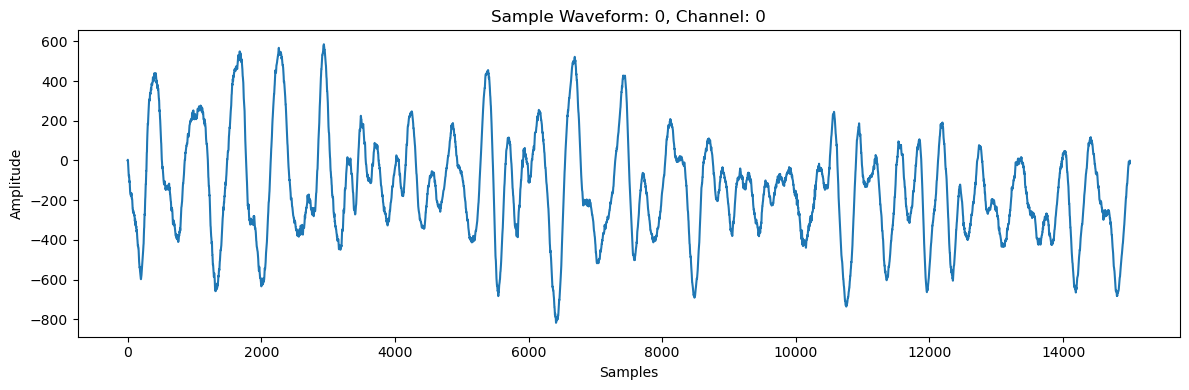

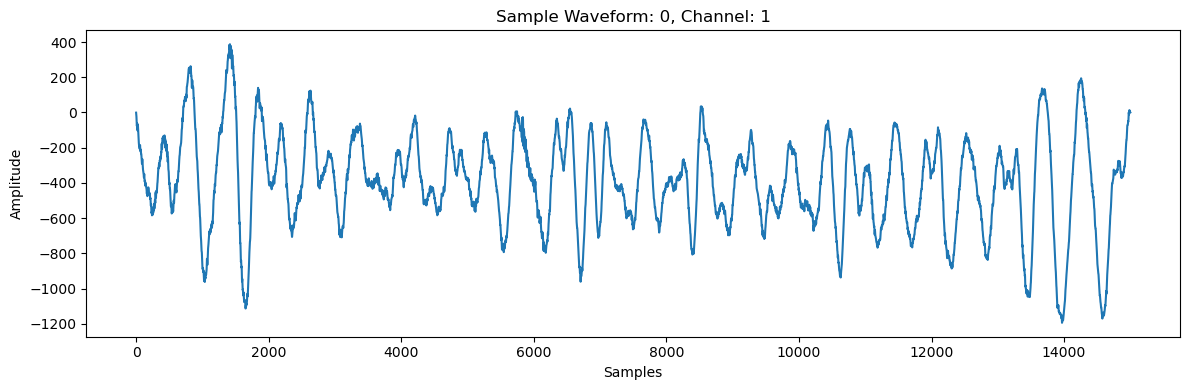

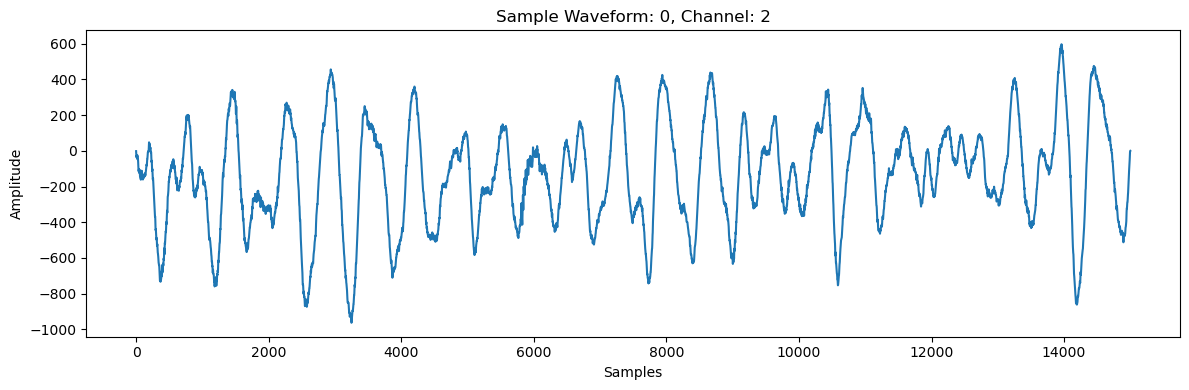

Total number of waveforms processed: 9786


In [44]:
total_num_waveforms = 0
with h5py.File(output_waveform_file, 'r') as f:
    print("Keys in HDF5 file:")
    for key in f.keys():
        print(f" - {key}")
    print(f['data'].keys())

    waveforms_group = f['data']

    for i, key in enumerate(list(waveforms_group.keys())[:]):
                waveform = waveforms_group[key][:]
                print(f" - {key}: shape={waveform.shape}, min={waveform.min():.2f}, max={waveform.max():.2f}")
                total_num_waveforms += waveform.shape[0]

    # Plot a sample waveform if matplotlib is available
    if list(waveforms_group.keys()):
        sample_key = list(waveforms_group.keys())[0]
        sample_waveform = waveforms_group[sample_key][:]

        print('samplewaveform shape:', sample_waveform[0].shape)

        for i in range(len(sample_waveform[0])):
            plt.figure(figsize=(12, 4))
            y = sample_waveform[0,i,:]
            x = np.arange(len(y))
            plt.plot(x, y)
            plt.title(f"Sample Waveform: {sample_key}, Channel: {i}")
            plt.xlabel("Samples")
            plt.ylabel("Amplitude")
            plt.tight_layout()
            plt.show()
        

print(f"Total number of waveforms processed: {total_num_waveforms}")
    

In [48]:
metadata = pd.read_csv(output_metadata_file)
metadata.iloc[0:10][['event_id','source_origin_time','source_latitude_deg','source_longitude_deg','source_depth_km','station_network_code','station_channel_code','station_code','station_latitude_deg','station_longitude_deg','trace_name','trace_P_arrival_sample', 'trace_S_arrival_sample','trace_P_onset','trace_S_onset','trace_start_time']]

,event_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,station_network_code,station_channel_code,station_code,station_latitude_deg,station_longitude_deg,trace_name,trace_P_arrival_sample,trace_S_arrival_sample,trace_P_onset,trace_S_onset,trace_start_time
0,ev1289640038_820443,1.289640e+09,46.46399,-122.37395,12.994,UW,BH,PASS,NaN,NaN,"7$0,:3,:15000",9206.0,NaN,impulsive,NaN,2010-11-13T09:19:48.820443Z
1,ev1289640038_820443,1.289640e+09,46.46399,-122.37395,12.994,TA,BH,E04D,NaN,NaN,"3$0,:3,:15000",NaN,5587.0,NaN,impulsive,2010-11-13T09:19:48.820443Z
2,ev1289646219_581208,1.289646e+09,46.45339,-122.28806,8.582,TA,BH,E04D,NaN,NaN,"6$0,:3,:15000",5390.0,5725.0,impulsive,impulsive,2010-11-13T11:02:49.581208Z
3,ev1289661539_462542,1.289662e+09,47.58415,-122.74959,16.593,UW,BH,DOSE,NaN,NaN,"4$0,:3,:15000",NaN,5781.0,NaN,impulsive,2010-11-13T15:18:09.462542Z
4,ev1289670652_802892,1.289671e+09,47.71158,-122.58572,21.296,UW,BH,DOSE,NaN,NaN,"9$0,:3,:15000",NaN,5986.0,NaN,impulsive,2010-11-13T17:50:02.802892Z
5,ev1289670652_802892,1.289671e+09,47.71158,-122.58572,21.296,TA,BH,B05D,NaN,NaN,"4$1,:3,:15000",NaN,7020.0,NaN,impulsive,2010-11-13T17:50:02.802892Z
6,ev1289678332_928612,1.289678e+09,45.99873,-122.11309,14.316,UW,BH,YACT,NaN,NaN,"0$0,:3,:15000",NaN,5824.0,NaN,impulsive,2010-11-13T19:58:02.928612Z
7,ev1289680261_012108,1.289680e+09,47.72763,-120.31876,0.800,TA,BH,B05D,NaN,NaN,"8$0,:3,:15000",7393.0,9103.0,impulsive,impulsive,2010-11-13T20:30:11.012108Z
8,ev1289680261_012108,1.289680e+09,47.72763,-120.31876,0.800,TA,BH,E04D,NaN,NaN,"10$0,:3,:15000",8501.0,11052.0,impulsive,impulsive,2010-11-13T20:30:11.012108Z
9,ev1289680261_012108,1.289680e+09,47.72763,-120.31876,0.800,UW,BH,DOSE,NaN,NaN,"3$1,:3,:15000",NaN,10480.0,NaN,impulsive,2010-11-13T20:30:11.012108Z
